In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

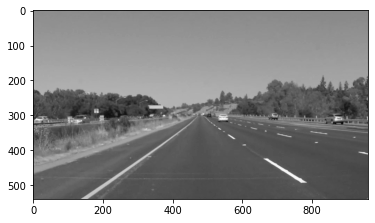

In [2]:
# 灰度化
img = cv2.imread('lane.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, 'gray')
plt.show()

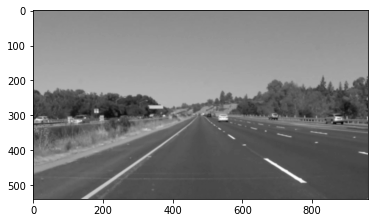

In [3]:
# 高斯模糊
blur_ksize = 5
blur_gray = cv2.GaussianBlur(img_gray, (blur_ksize, blur_ksize), 1)
plt.imshow(blur_gray, 'gray')
plt.show()

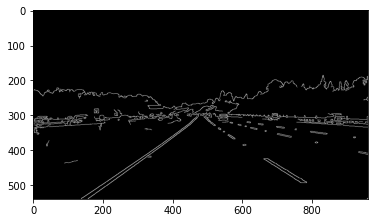

In [4]:
# Canny边缘检测
# Canny边缘检测高低阈值
canny_lth = 50
canny_hth = 150
edges = cv2.Canny(blur_gray, canny_lth, canny_hth)
plt.imshow(edges, 'gray')
plt.show()

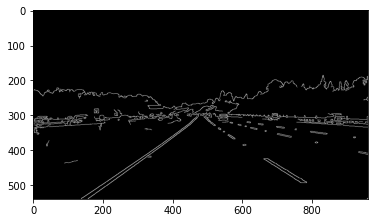

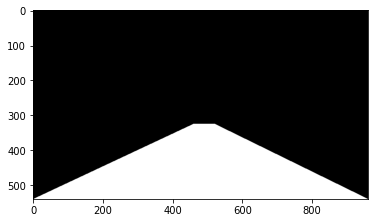

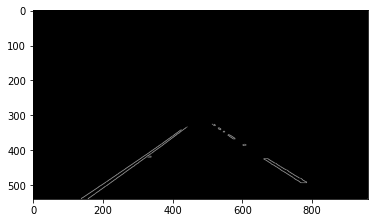

In [5]:
# 不规则ROI区域截取
mask = np.zeros_like(blur_gray)
corner_points = np.array([[
    [0, mask.shape[0]],
    [mask.shape[1], mask.shape[0]],
    [520, 325],
    [460, 325]
]])
cv2.fillPoly(mask, corner_points, 255)
masked_img = cv2.bitwise_and(edges, mask)
plt.imshow(edges, 'gray')
plt.show()
plt.imshow(mask, 'gray')
plt.show()
plt.imshow(masked_img, 'gray')
plt.show()

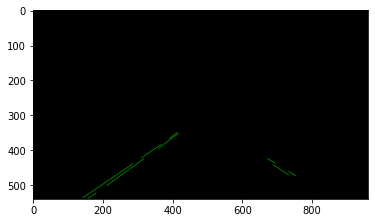

In [6]:
# 霍夫直线检测
rho = 1
theta = np.pi / 180
threshold = 15
min_line_len = 40
max_line_gap = 20
lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
drawing = cv2.cvtColor(np.zeros_like(masked_img), cv2.COLOR_GRAY2BGR)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(drawing, (x1, y1), (x2, y2), (0, 255, 0), 1, lineType=cv2.LINE_AA)
plt.imshow(drawing, 'gray')
plt.show()

In [7]:
# 车道计算
# 划分左右车道
left_lines, right_lines = [], []
for line in lines:
    x1, y1, x2, y2 = line[0]
    if (y2 - y1)/(x2 - x1) < 0:
        left_lines.append(line[0])
    else:
        right_lines.append(line[0])

In [8]:
# 清理异常数据
def clean_lines(lines, threshold):
    # 迭代计算斜率均值，排除掉与差值差异较大的数据
    slope = [(y2 - y1) / (x2 - x1) for x1, y1, x2, y2 in lines]
    while len(lines) > 0:
        mean = np.mean(slope)
        diff = [abs(s - mean) for s in slope]
        idx = np.argmax(diff)
        if diff[idx] > threshold:
            slope.pop(idx)
            lines.pop(idx)
        else:
            break
clean_lines(left_lines, 0.1)
clean_lines(right_lines, 0.1)

In [9]:
left_point = [[x1, y1] for x1, y1, x2, y2 in left_lines]
left_point += [[x2, y2] for x1, y1, x2, y2 in left_lines]
left_point = np.array(left_point)

In [10]:
right_point = [[x1, y1] for x1, y1, x2, y2 in right_lines]
right_point += [[x2, y2] for x1, y1, x2, y2 in right_lines]
right_point = np.array(right_point)

In [11]:
# 最小二乘法拟合
fit = np.polyfit(left_point[:,1], left_point[:,0], 1)
fit_fn = np.poly1d(fit)
left_results = [[fit_fn(325), 325],[fit_fn(masked_img.shape[0]), masked_img.shape[0]]]

In [12]:
fit = np.polyfit(right_point[:,1], right_point[:,0], 1)
fit_fn = np.poly1d(fit)
right_results = [[fit_fn(325), 325],[fit_fn(masked_img.shape[0]), masked_img.shape[0]]]

In [13]:
vtxs = np.array([[left_results[1], left_results[0], right_results[0], right_results[1]]], dtype=np.int)
img_copy = np.zeros_like(img)
img_copy = cv2.fillPoly(img_copy, vtxs, (0, 255, 0))

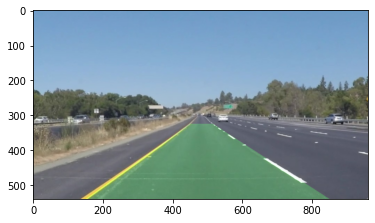

In [14]:
plt.imshow(cv2.addWeighted(img, 1, img_copy, 0.2, 0)[:,:,::-1])
plt.show()